## 1. Spectogram, mel spectogram и MFCC

In [2]:
import librosa
import librosa.display
import numpy as np
import torchaudio
import torch
import torchaudio.functional as F
import IPython.display as ipd
import nemo
import nemo.collections.asr as nemo_asr
import matplotlib.pyplot as plt
from nemo.collections.asr.metrics.wer import word_error_rate
from IPython.display import Audio
import glob

[NeMo W 2023-04-13 17:19:29 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-04-13 17:19:30 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [1]:
!pip install -q nemo_toolkit[all]

In [5]:
# Меняем частоту дискретизации на 16000
audio_data = 'data/1.wav'
sampling_freq = 16000
y, sr = librosa.load(audio_data, sr=sampling_freq)
print(type(y), type(sr))
print(y.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(245126,) 16000


In [6]:
ipd.Audio(audio_data)

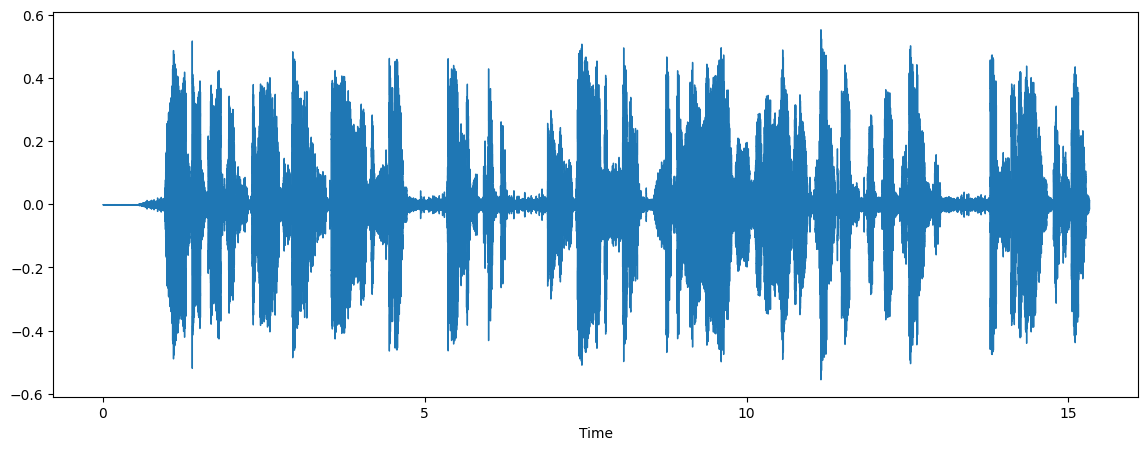

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
pass

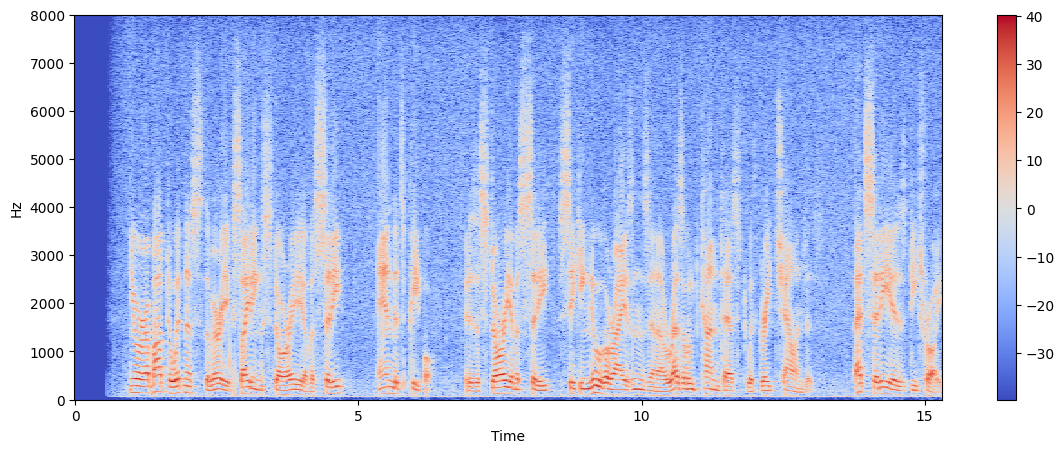

In [8]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
pass

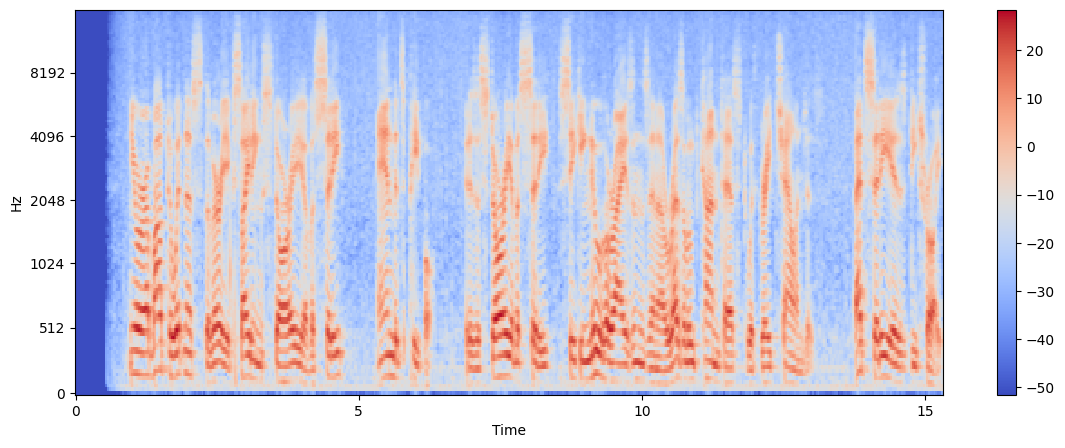

In [9]:
melspec = librosa.feature.melspectrogram(y=y, sr=sr)
melspec = librosa.power_to_db(melspec).astype(np.float32)
plt.figure(figsize=(14, 5))
librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=sr, fmax=16000)
plt.colorbar()
pass

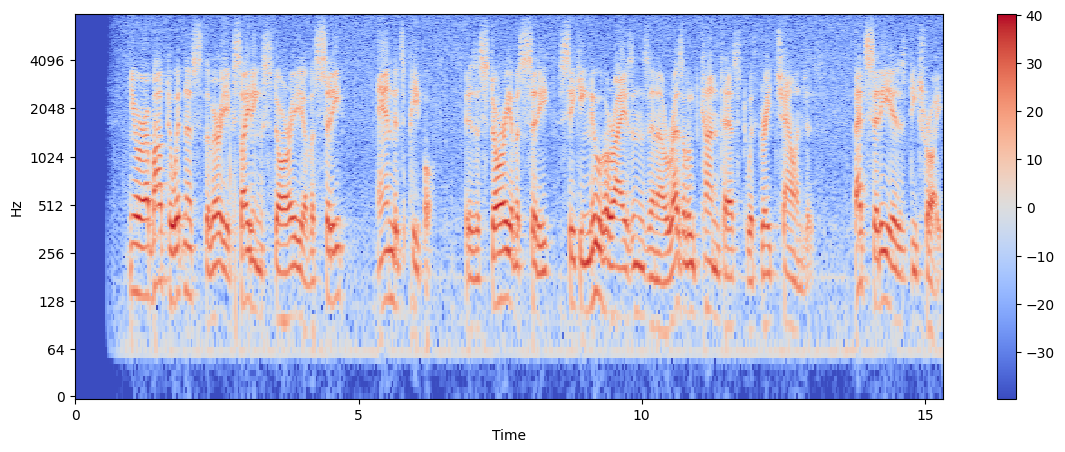

In [10]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
pass

(20, 479)


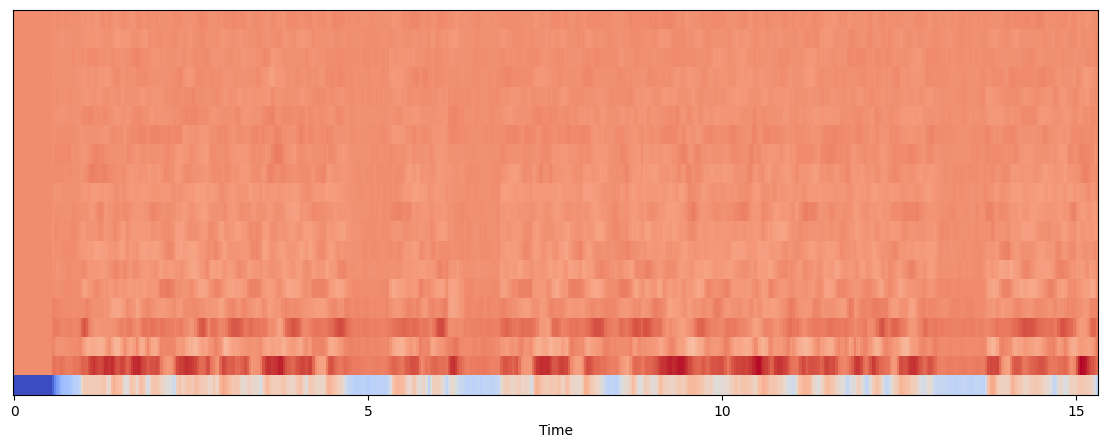

In [11]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print(mfccs.shape)
# Отображение MFCC:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
pass

## 2. TorchAudio

Effects applied

In [12]:
# загрузка данных
waveform1, sample_rate1 = torchaudio.load(audio_data)

# определение эффектов
effects = [
    ["lowpass", "-1", "300"],  # применение однополюсный фильтр нижних частот
    ["speed", "0.8"],  # уменьшение скорость
    # Это изменяет только частоту дискретизации, поэтому 
    # после этого необходимо добавить эффект `rate` с исходной частотой дискретизации.
    ["rate", f"{sample_rate1}"],
    ["reverb", "-w"],  # реверберация придает некоторое драматическое ощущение
]

# Применяем эффекты
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)

print(waveform1.shape, sample_rate1)
print(waveform2.shape, sample_rate2)

torch.Size([1, 245126]) 16000
torch.Size([2, 306408]) 16000


In [13]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [14]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

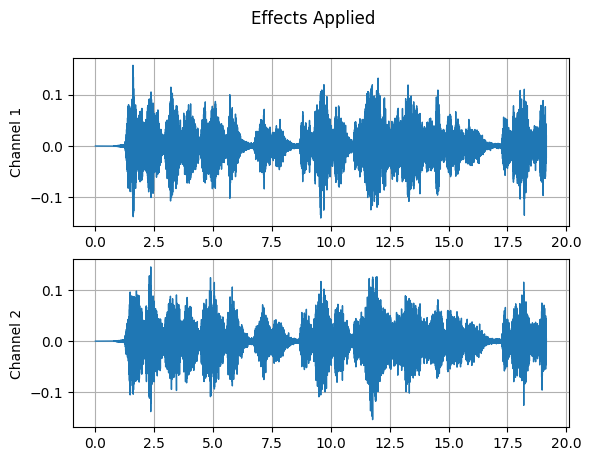

[NeMo W 2023-04-13 17:21:23 nemo_logging:349] /usr/local/lib/python3.9/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
      Z = 10. * np.log10(spec)
    


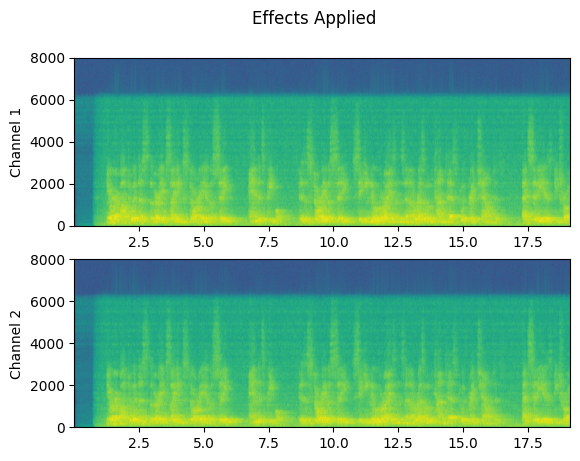

In [15]:
plot_waveform(waveform2, sample_rate2, title="Effects Applied")
plot_specgram(waveform2, sample_rate2, title="Effects Applied")
Audio(waveform2, rate=sample_rate2)

Simulating room reverberation

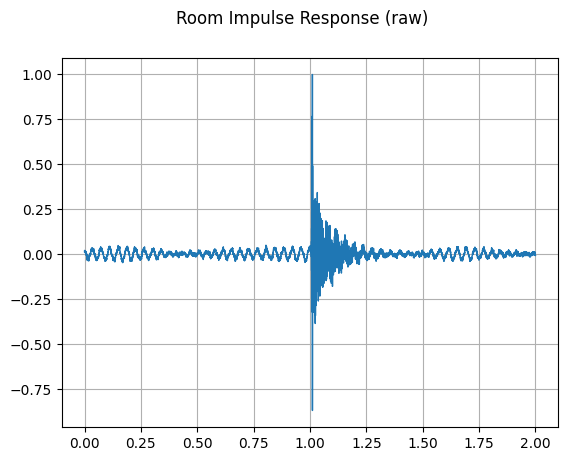

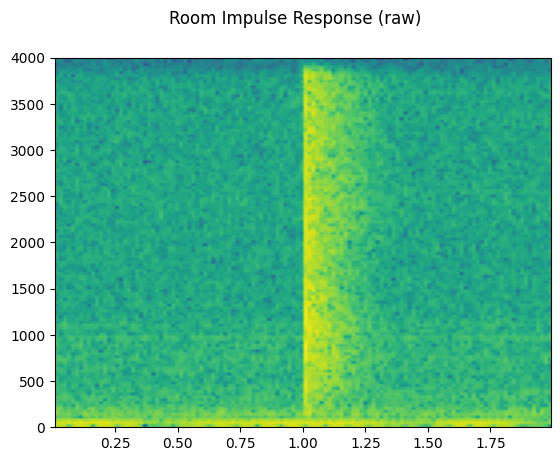

In [16]:
rir_raw, sample_rate = torchaudio.load("rir.wav")
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

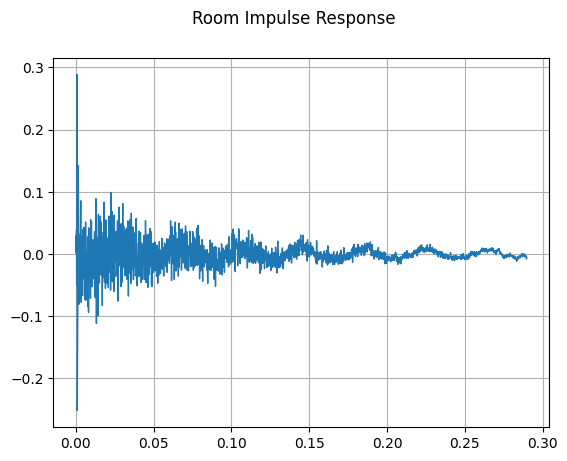

In [17]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.norm(rir, p=2)
RIR = torch.flip(rir, [1])

plot_waveform(rir, sample_rate, title="Room Impulse Response")

In [20]:
waveform1, sample_rate1 = torchaudio.load("data/2.wav")
augmented = F.fftconvolve(waveform1, rir)

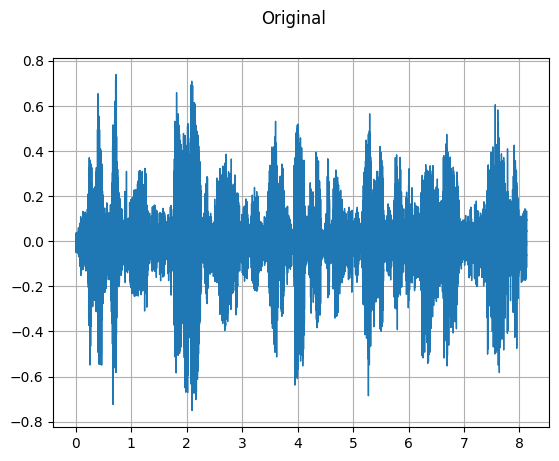

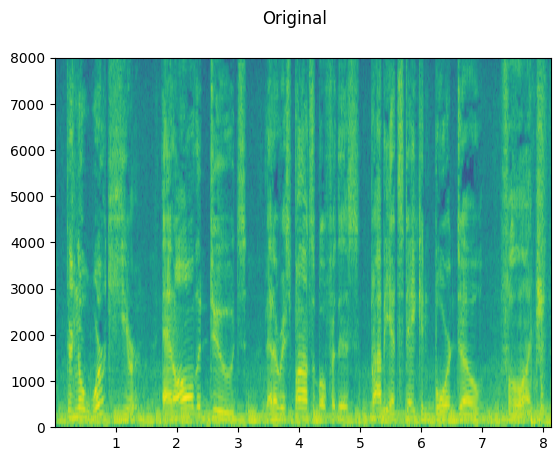

In [21]:
plot_waveform(waveform1, sample_rate1, title="Original")
plot_specgram(waveform1, sample_rate1, title="Original")
Audio(waveform1, rate=sample_rate1)

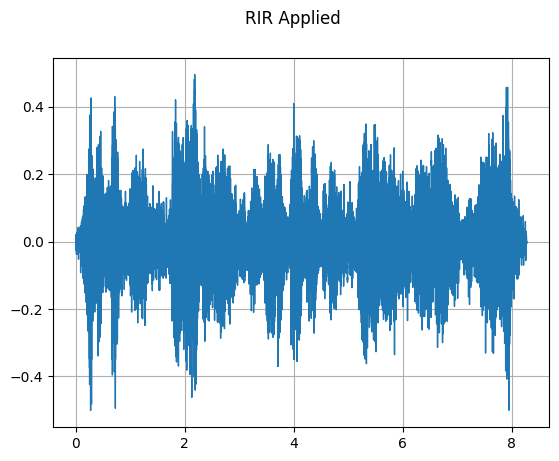

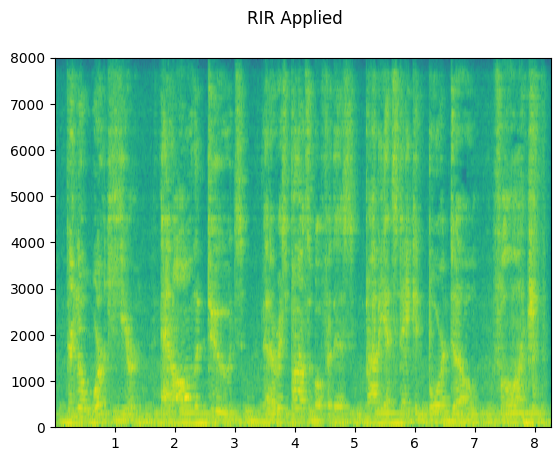

In [22]:
plot_waveform(augmented, sample_rate1, title="RIR Applied")
plot_specgram(augmented, sample_rate1, title="RIR Applied")
Audio(augmented, rate=sample_rate1)

## 3. Pipeline

In [43]:
data_wav = sorted(glob.glob("data/*.wav"))
data_txt = sorted(glob.glob("data/*.txt"))
lst_txt = []

for path in data_txt:
    with open(path, "r") as transcription:
        lst_txt.append(transcription.read())
lst_txt = np.array(lst_txt)

In [36]:
data_wav

['data/1.wav', 'data/2.wav', 'data/3.wav', 'data/4.wav']

In [37]:
data_txt

['data/1.txt', 'data/2.txt', 'data/3.txt', 'data/4.txt']

In [38]:
lst_txt

array(['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit',
       "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch",
       'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria',
       'after all superfluous flesh is gone what is left is stringy and resistant'],
      dtype='<U183')

In [39]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2023-04-13 17:26:38 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.17.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2023-04-13 17:26:43 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-04-13 17:26:44 features:287] PADDING: 16
[NeMo I 2023-04-13 17:26:46 save_restore_connector:247] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.17.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [40]:
def calc_wer(model, path, txt):
    pred = model.transcribe(paths2audio_files=path)
    wer = word_error_rate(pred, txt)
    return wer

In [44]:
calc_wer(quartznet, data_wav, lst_txt)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

0.0875

In [45]:
import os

In [46]:
if not os.path.exists("scripts/tokenizers/process_asr_text_tokenizer.py"):
  !mkdir scripts
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tokenizers/process_asr_text_tokenizer.py

--2023-04-13 17:29:04--  https://raw.githubusercontent.com/NVIDIA/NeMo//scripts/tokenizers/process_asr_text_tokenizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /NVIDIA/NeMo/scripts/tokenizers/process_asr_text_tokenizer.py [following]
--2023-04-13 17:29:04--  https://raw.githubusercontent.com/NVIDIA/NeMo/scripts/tokenizers/process_asr_text_tokenizer.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 404 Not Found
2023-04-13 17:29:04 ERROR 404: Not Found.



In [47]:
asr_model_jasper = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_en_jasper10x5dr")

[NeMo I 2023-04-13 17:29:10 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_jasper10x5dr/versions/1.0.0rc1/files/stt_en_jasper10x5dr.nemo to /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo
[NeMo I 2023-04-13 17:29:47 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-04-13 17:30:05 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2023-04-13 17:30:05 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data2/vo

[NeMo I 2023-04-13 17:30:05 features:287] PADDING: 16
[NeMo I 2023-04-13 17:30:13 save_restore_connector:247] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo.


In [48]:
calc_wer(asr_model_jasper, data_wav, lst_txt)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

0.05

In [49]:
asr_model_citrinet = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_256")

[NeMo I 2023-04-13 17:30:29 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_citrinet_256/versions/1.0.0rc1/files/stt_en_citrinet_256.nemo to /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_citrinet_256/91a9cc5850784b2065e8a0aa3d526fd9/stt_en_citrinet_256.nemo
[NeMo I 2023-04-13 17:30:32 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-04-13 17:30:33 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2023-04-13 17:30:34 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2023-04-13 17:30:34 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2023-04-13 17:30:34 modelPT:174] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a va

[NeMo I 2023-04-13 17:30:34 features:287] PADDING: 16
[NeMo I 2023-04-13 17:30:36 save_restore_connector:247] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.17.0/stt_en_citrinet_256/91a9cc5850784b2065e8a0aa3d526fd9/stt_en_citrinet_256.nemo.


In [50]:
calc_wer(asr_model_citrinet, data_wav, lst_txt)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

0.075